In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

/Users/sonpro2002/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sonpro2002/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
base_folder = "Result"

# Fit Regression Model


## Input

* `samples_for_model.csv` - Observations 
    * user (int) - User identifier
    * week_index (int) - Week in the study period
    * count (int) - Number of items recommended to the user in this week
    * weeks_since_signup (int) - Number of weeks since the user's first interaction
    * variety (int) - Variety in topics or political

## Output

* `exp_coeff_table.csv` - Table with exponentiated coefficients (Intercept and weeks_since_signup)
* `other_coeff_table.csv` - Table with all coefficients as estimated by the model

In [3]:
import pandas as pd
df = pd.read_csv(f"{base_folder}/samples_for_model.csv")

In [4]:
random_users = df['user'].sample(n=20, random_state=1)

# Tạo DataFrame mới chỉ chứa 20 người dùng được chọn
df_random_20_users = df[df['user'].isin(random_users)]

In [22]:
df_random_20_users.to_csv(f"{base_folder}/20random_users.csv",index=False)

In [ ]:
df_random_20_users

# Modeling

In [6]:
# GLMM model configuration
formula = """
variety ~ 
1 
+ (days_since_signup) 
+ (np.log(count)) 
+ (1|user) 
+ (1|day_index)
"""

In [7]:
# Parameters for the experiment
draws = 1000
tune = 3000

In [8]:
# 
model = bmb.Model(
    formula,
    df_random_20_users,
    family="negativebinomial",
    link="log",
    dropna=True,
    auto_scale=True
)


In [9]:
trace = model.fit(draws=draws, tune=tune, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [variety_alpha, Intercept, days_since_signup, np.log(count), 1|user_sigma, 1|user_offset, 1|day_index_sigma, 1|day_index_offset]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/sonpro2002/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sonpro2002/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/sonpro2002/opt/anaconda3/lib/python3.9/site-packages/pan

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 81 seconds.


Sampling: [1|day_index_sigma, 1|user_sigma, Intercept, days_since_signup, np.log(count), variety_alpha]


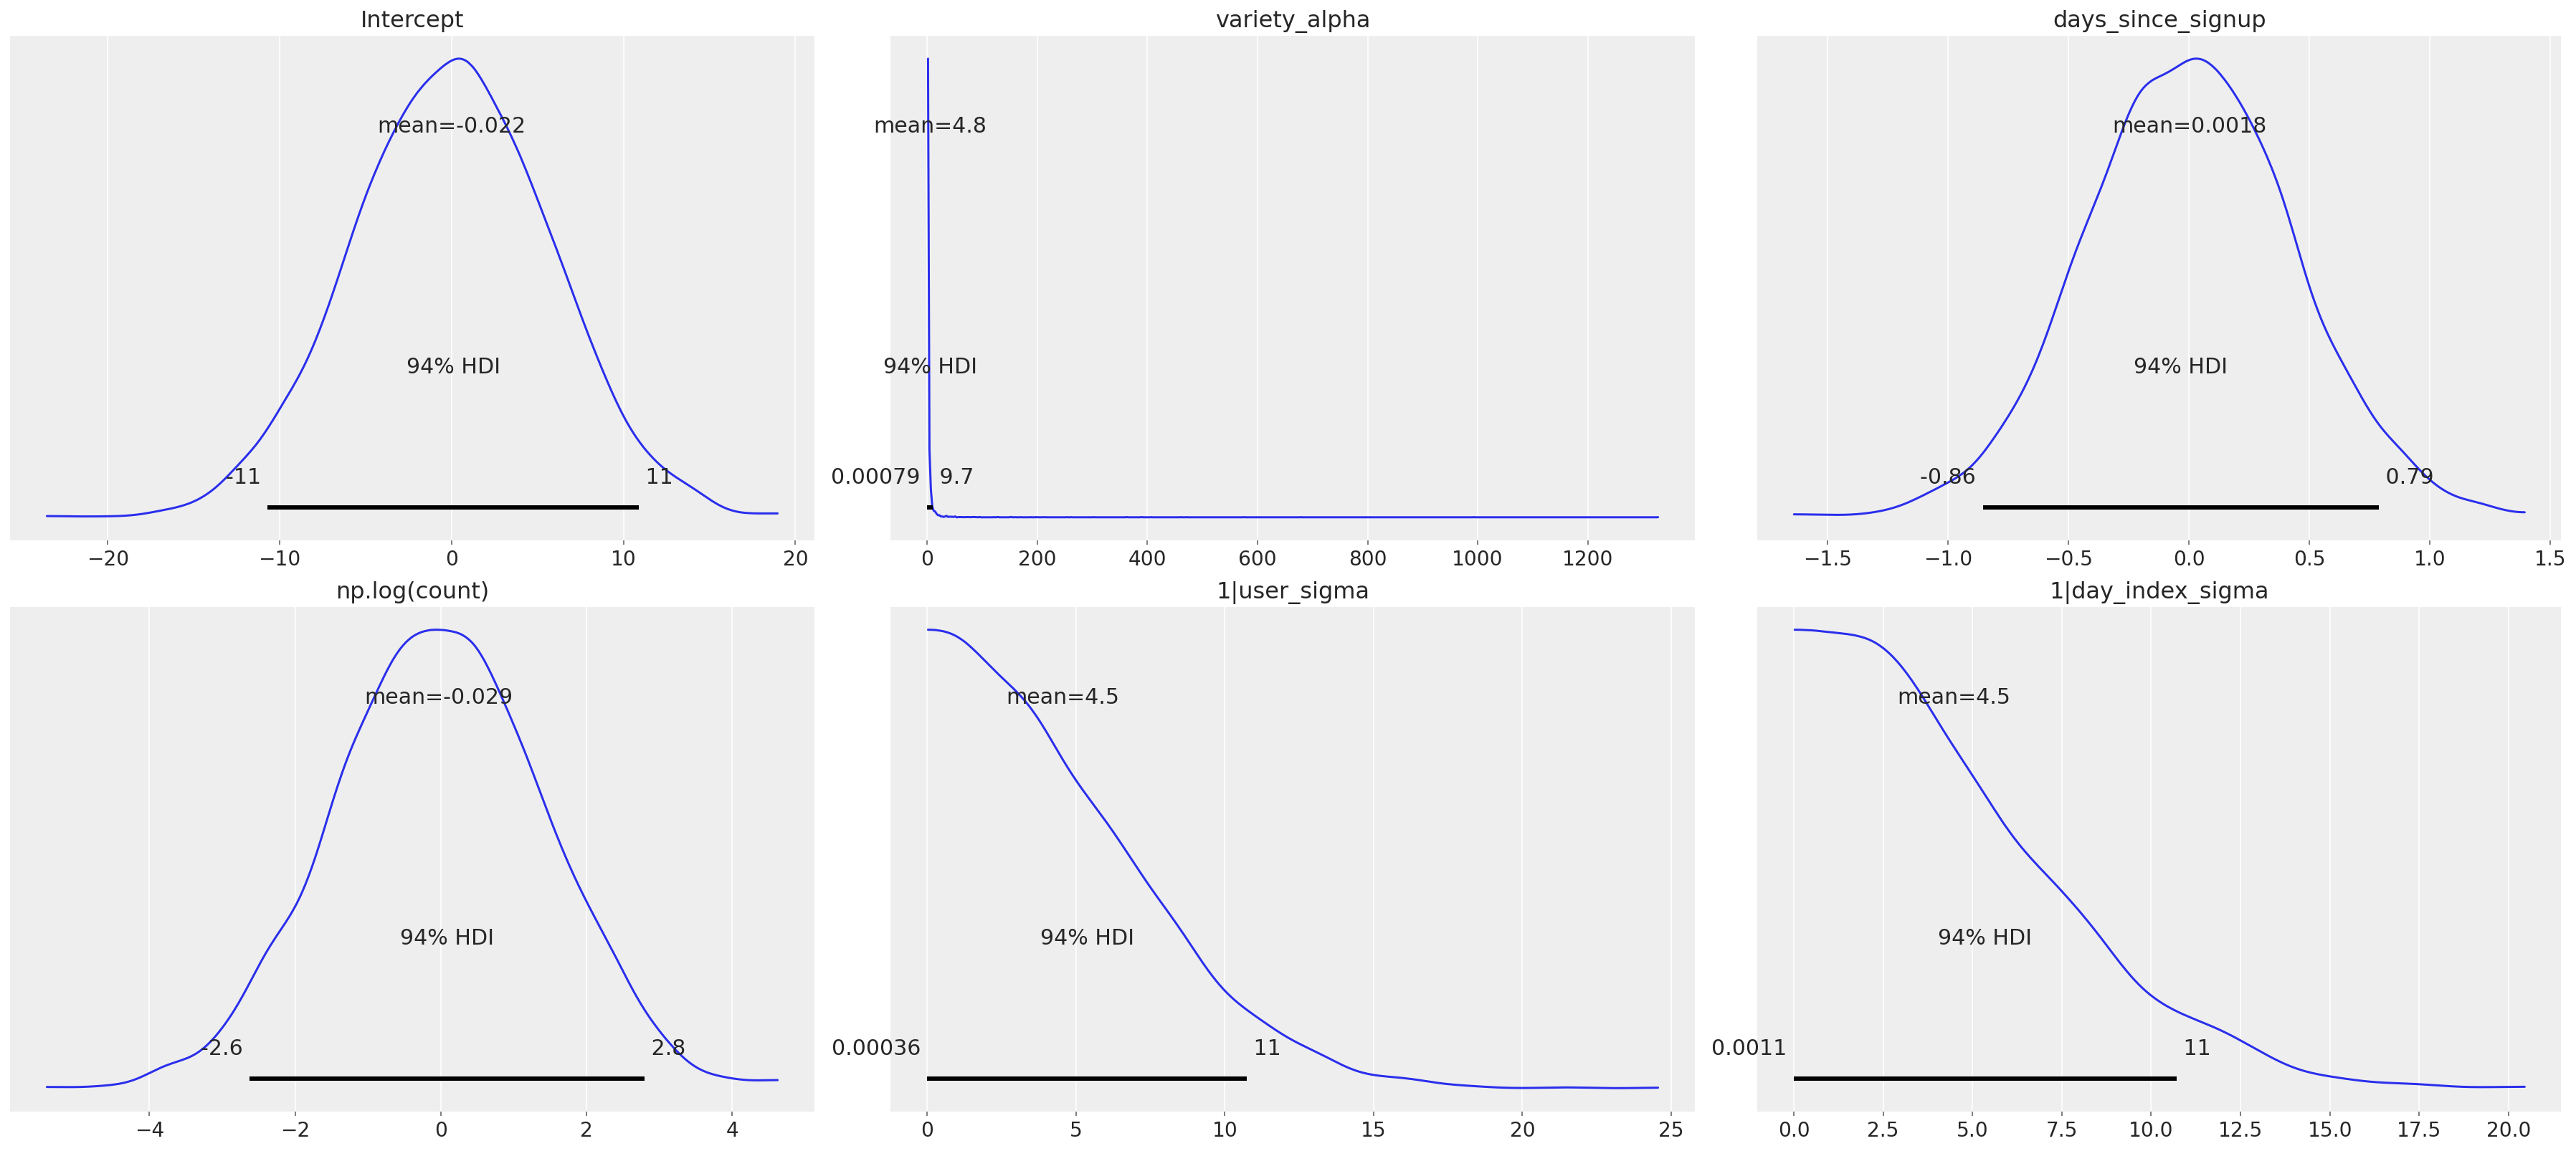

In [10]:
model.plot_priors()
plt.savefig(f'{base_folder}/plot_priors.pdf', dpi=300)

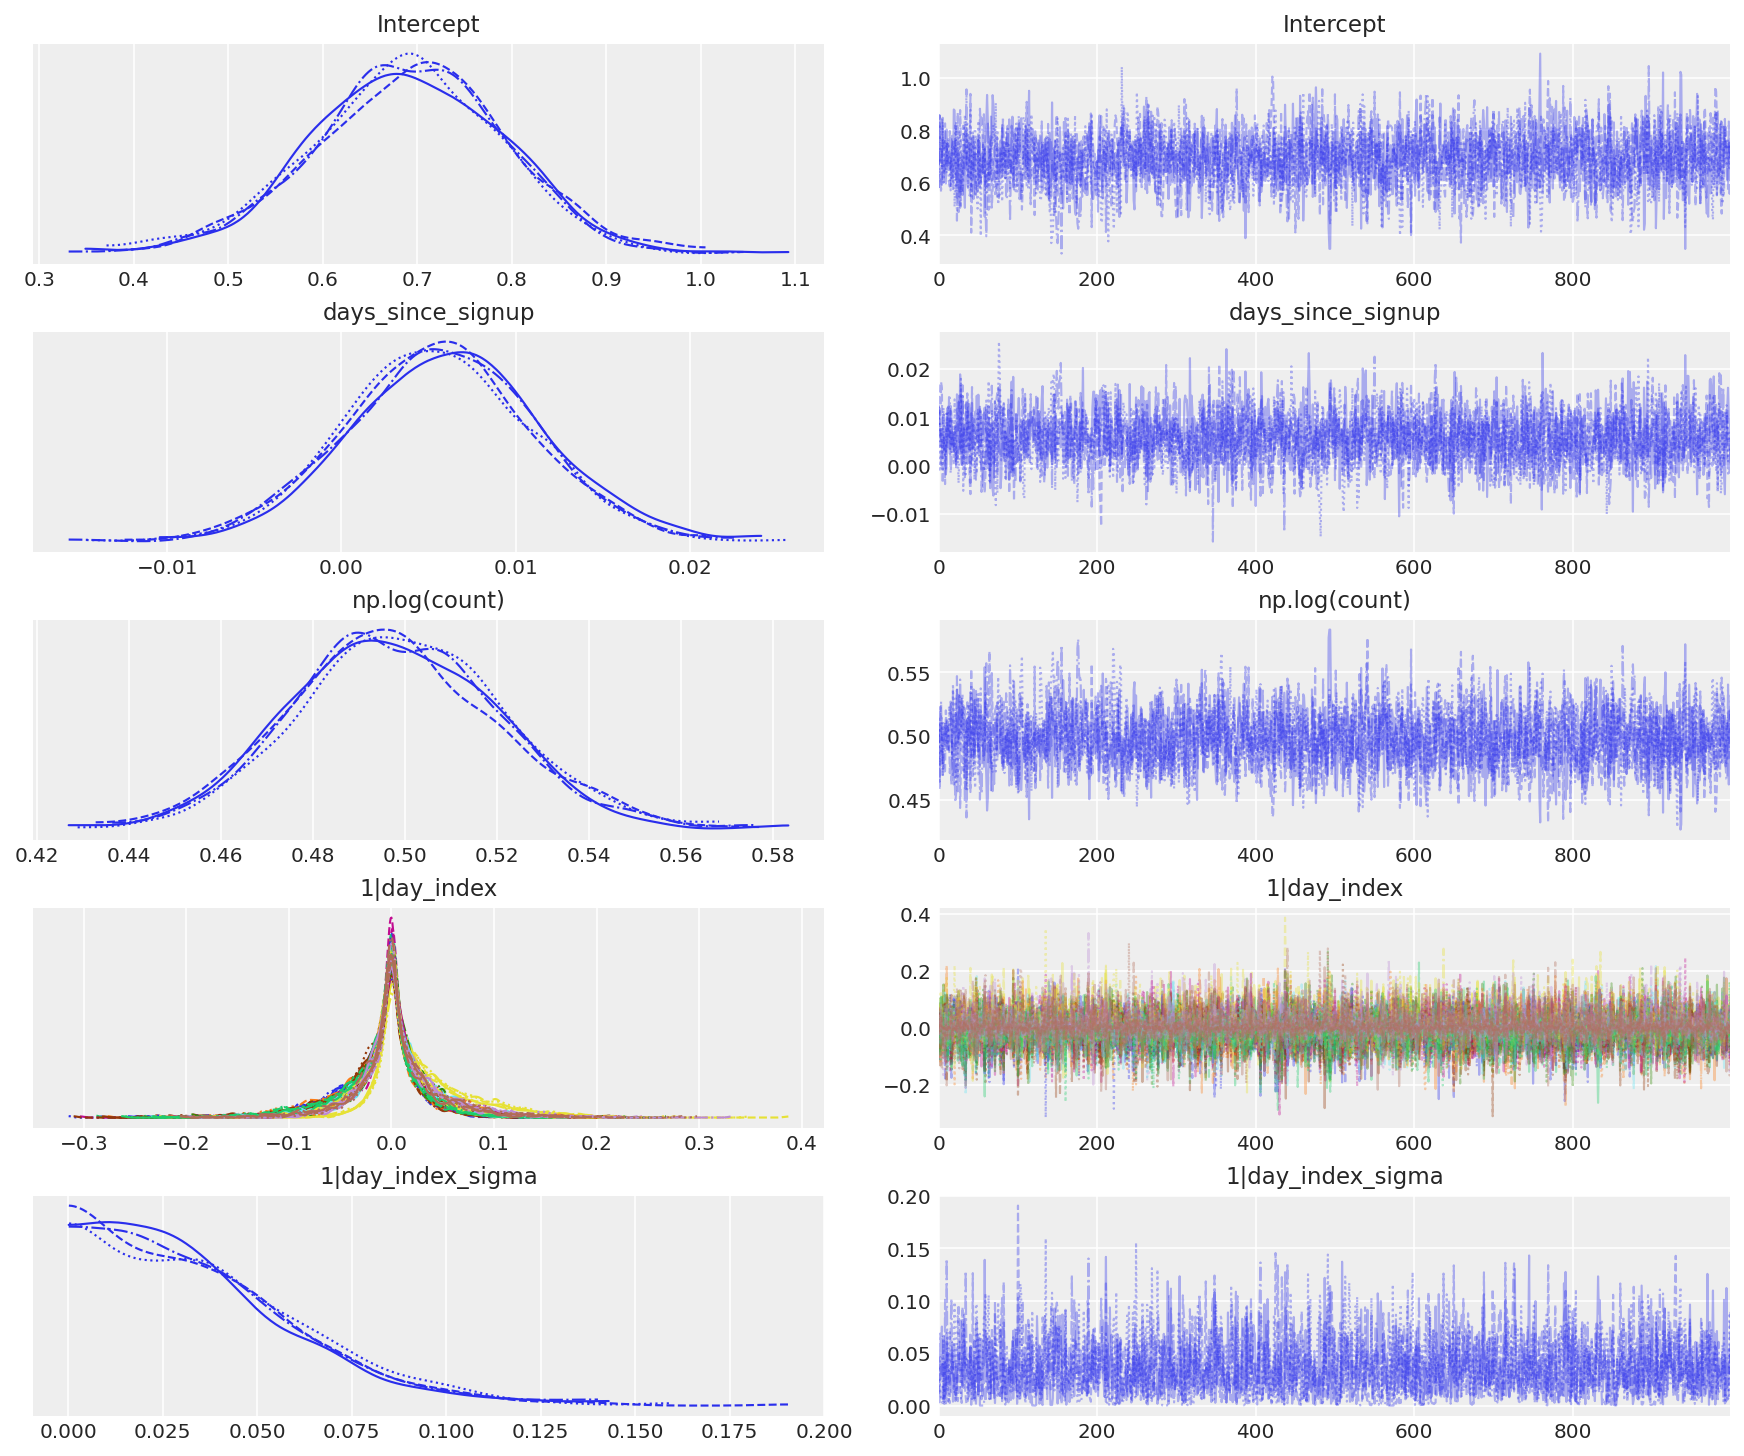

In [21]:
az.plot_trace(trace, var_names=["Intercept", "days_since_signup",
              "np.log(count)", "1|day_index", "1|day_index_sigma"])
plt.savefig(f'{base_folder}/plot_trace.pdf', dpi=300)

In [12]:
exp_coeff_table = az.summary(
    np.exp(trace.posterior), var_names=[
        "Intercept",
        "days_since_signup",
    ]
)

/Users/sonpro2002/opt/anaconda3/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


In [14]:
exp_coeff_table
    
exp_coeff_table.to_csv(f"{base_folder}/exp_coeff_table.csv", header=True, index=True)
    

In [15]:
coeff_table = az.summary(
        trace.posterior, var_names=[
            "Intercept",
            "days_since_signup",
            "np.log(count)",
            "1|day_index_sigma",
            "1|user_sigma",
            "variety_alpha"
        ]
    )

In [19]:

    
coeff_table.to_csv(f"{base_folder}/other_coeff_table.csv", header=True, index=True)

In [20]:
coeff_table

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.690,0.101,0.502,0.881,0.002,0.002,1834.0,2511.0,1.0
days_since_signup,0.006,0.005,-0.004,0.016,0.000,0.000,2137.0,2674.0,1.0
np.log(count),0.498,0.022,0.457,0.541,0.000,0.000,2260.0,2423.0,1.0
1|day_index_sigma,0.036,0.027,0.000,0.084,0.001,0.000,1490.0,1067.0,1.0
1|user_sigma,0.136,0.046,0.055,0.224,0.001,0.001,939.0,1385.0,1.0
variety_alpha,2882.419,75134.378,38.494,3756.121,1449.940,1025.373,3679.0,2438.0,1.0
